# Example Notebook for a pipeline

## 0. set log-level of sam_ml library [can be ignored]

(e.g. debugging)

NOTE: has to happen before importing the sam_ml library

In [1]:
import os
os.environ["SAM_ML_LOG_LEVEL"] = "info"

## 1. libraries

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sam_ml.models.classifier import LR
from sam_ml.models import create_pipeline
from sam_ml.data.preprocessing import Embeddings_builder, Sampler, Scaler, Selector

## 2. data

### 2.1. load dataset

In [3]:
df = load_iris()
y = pd.Series(df.target)
X = pd.DataFrame(df.data, columns=df.feature_names)
x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.80, random_state=42)

In [4]:
X.sample(6, random_state=42)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
73,6.1,2.8,4.7,1.2
18,5.7,3.8,1.7,0.3
118,7.7,2.6,6.9,2.3
78,6.0,2.9,4.5,1.5
76,6.8,2.8,4.8,1.4
31,5.4,3.4,1.5,0.4


In [5]:
# Flowers: Setosa (= 0), Versicolor (= 1) and Virginica (= 2)
y.sample(6, random_state=42)

73     1
18     0
118    2
78     1
76     1
31     0
dtype: int64

### 2.2. data preparation 
[not needed because already included in the pipeline]

## 3. model

All **Classifier** class methods apply also for Pipelines!!!

### 3.1. create pipeline

Every sam_ml Pipeline consists of 5 steps (4 data preparation + 1 model):

**vectorizer**: *Embeddings_builder* class object
- auto detects string columns and creates for every string column a vectorizer that vectorizes the columns
- to one-hot-encode a string column is equal to vectorizing it

**scaler**: *Scaler* class object
- scales the data

**selector**: *Selector* class object
- selectes features

**sampler**: *Sampler* class object
- up-/downsamples the data in training

**model**: *Classifier* subclass object
- predicts

for an easier use of pipelines, you can also just insert a string with the type of the vectorizer/scaler/selector/sampler instead of giving a class object. In this case, the default class object of this type will be used. If you insert **None**, the step will be skipped in the pipeline

In [6]:
model = create_pipeline(vectorizer=None, scaler="minmax", selector=Selector(algorithm="kbest", num_features=3), sampler="ros", model=LR(), model_name="pipy")

get the possible strings to enter with the **params** function from the data classes

In [7]:
print(Embeddings_builder.params())
print(Scaler.params())
print(Selector.params()) # algorithm parameter
print(Sampler.params())

{'algorithm': ['bert', 'count', 'tfidf']}
{'algorithm': ['standard', 'minmax', 'maxabs', 'robust', 'normalizer', 'power', 'quantile', 'quantile_normal']}
{'algorithm': ['kbest', 'kbest_chi2', 'pca', 'wrapper', 'sequential', 'select_model', 'rfe', 'rfecv'], 'estimator': [LinearSVC(dual=False, penalty='l1'), LogisticRegression(), ExtraTreesClassifier(n_estimators=50)]}
{'algorithm': ['SMOTE', 'BSMOTE', 'rus', 'ros', 'tl', 'nm', 'cc', 'oss']}


you can use the **steps** attribute to get the components of the pipeline. 

**Note:** the model information will be given as tuple consisting of the sklearn model, the model_type and the hyperparameter tuning grid

In [8]:
model.steps

[('vectorizer', None),
 ('scaler', Scaler(algorithm='minmax', )),
 ('selector', Selector(num_features=3, )),
 ('sampler', Sampler()),
 ('model', LR(model_name='LogisticRegression'))]

### 3.2. simple training

train and evaluate your pipeline

In [9]:
model.train(x_train, y_train)
model.evaluate(x_test, y_test)

Train score: 0.9333333333333333 - Train time: 0:00:00
accuracy: 1.0
precision: 1.0
recall: 1.0
s_score: 0.9926004570086354
l_score: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9926004570086354,
 'l_score': 1.0}

get the importance of the different features of your model

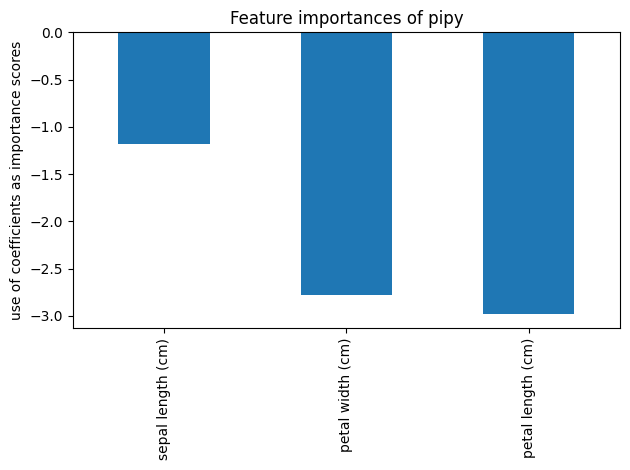

In [10]:
model.feature_importance()

predict with your model

In [11]:
test_df = pd.DataFrame([[1.3, 1.3, 1.3, 1.3], [6.5, 1.6, 8.6, 2.4]], columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])
test_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,1.3,1.3,1.3,1.3
1,6.5,1.6,8.6,2.4


In [12]:
model.predict(test_df)

[0, 2]

### 3.3. hyperparameter tuning

#### 3.3.1. RandomCVSearch

you can get the hyperparameter tuning grid as followed:

In [13]:
model.grid

Configuration space object:
  Hyperparameters:
    C, Type: UniformFloat, Range: [0.01, 100.0], Default: 1.0, on log-scale
    l1_ratio, Type: UniformFloat, Range: [0.01, 1.0], Default: 0.1
    penalty, Type: Categorical, Choices: {l2, elasticnet}, Default: l2
    solver, Type: Categorical, Choices: {newton-cg, lbfgs, liblinear, sag, saga}, Default: lbfgs, Probabilities: (0.15, 0.15, 0.15, 0.15, 0.4)
  Conditions:
    l1_ratio | penalty == 'elasticnet'
  Forbidden Clauses:
    (Forbidden: penalty == 'elasticnet' && Forbidden: solver in {'lbfgs', 'liblinear', 'newton-cg', 'sag'})

simple scoring with recall/precision/accurracy

In [16]:
best_hyperparam, best_score = model.randomCVsearch(x_train, y_train, scoring="recall", avg="macro")
best_hyperparam, best_score

randomCVsearch (pipy): 100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


({'C': 75.56810141274431, 'penalty': 'l2', 'solver': 'newton-cg'},
 0.9507936507936507)

In [17]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score: 0.9583333333333334 - Train time: 0:00:00
accuracy: 1.0
precision: 1.0
recall: 1.0
s_score: 0.9926004570086354
l_score: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9926004570086354,
 'l_score': 1.0}

advanced scoring with s_score/l_score:
- **secondary_scoring** and **pos_label** to priorities metrics/classes in optimization
- **strength** to set how much the priorization is compared to scores in all the other metrics/classes
- always includes all metrics/classes and punishes really bad scores in one metric/class

In [18]:
best_hyperparam, best_score = model.randomCVsearch(x_train, y_train, scoring="s_score", secondary_scoring="recall", pos_label=-1, strength=4)
best_hyperparam, best_score

randomCVsearch (pipy): 100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


({'C': 7.128188058401368, 'penalty': 'l2', 'solver': 'newton-cg'},
 0.8478310787898501)

In [19]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score: 0.9416666666666667 - Train time: 0:00:00
accuracy: 1.0
precision: 1.0
recall: 1.0
s_score: 0.9926004570086354
l_score: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9926004570086354,
 'l_score': 1.0}

#### 3.3.2. SMAC3 library *HyperparameterOptimizationFacade*

In [20]:
best_hyperparam = model.smac_search(x_train, y_train, scoring="recall", avg="macro")
best_hyperparam

[INFO][abstract_initial_design.py:147] Using 3 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:515] Added config 12be8a as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config ce10f4 and rejected config 12be8a as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:319] Finished 50 trials.
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: 593.9823989868164
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 0


Configuration(values={
  'C': 68.66295315779564,
  'penalty': 'l2',
  'solver': 'lbfgs',
})

In [21]:
best_model = model.get_deepcopy()
best_model.set_params(**best_hyperparam)
best_model.train(x_train, y_train)
best_model.evaluate(x_test, y_test)

Train score: 0.9583333333333334 - Train time: 0:00:00
accuracy: 1.0
precision: 1.0
recall: 1.0
s_score: 0.9926004570086354
l_score: 1.0

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 's_score': 0.9926004570086354,
 'l_score': 1.0}

### 3.4. cross validation

#### 3.4.1. all-vs-one cross validation

**Concept:**

The model will be trained on all datapoints except one and then tested on this last one. This will be repeated for all datapoints so that we have our predictions for all datapoints.

**Advantage:** optimal use of information for training

**Disadvantage:** long train time

This concept is very useful for small datasets (datapoints < 150) because the long train time is still not too long and especially with a small amount of information for the model, it is important to use all the information one has for the training.

In [22]:
model.cross_validation_small_data(X, y, avg="macro")

pipy: 100%|██████████| 150/150 [00:02<00:00, 56.37it/s]

accuracy: 0.9533333333333334
precision: 0.9534480458850206
recall: 0.9533333333333333
s_score: 0.9861117444423929
l_score: 0.9999998737227318
train_score: 0.9533333333333333
train_time: 0:00:00

classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.92      0.94      0.93        50
           2       0.94      0.92      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



{'accuracy': 0.9533333333333334,
 'precision': 0.9534480458850206,
 'recall': 0.9533333333333333,
 's_score': 0.9861117444423929,
 'l_score': 0.9999998737227318,
 'train_score': 0.9533333333333333,
 'train_time': '0:00:00'}

#### 3.4.2. multiple split cross validation

In [23]:
model.cross_validation(X, y, cv_num=5, avg="macro")


                                0         1         2         3         4  \
fit_time                 0.012844  0.018839  0.013365  0.016835  0.019885   
score_time               0.017242  0.013445  0.014844  0.018109  0.019604   
test_precision (macro)   1.000000  0.666667  0.500000  0.916667  0.500000   
train_precision (macro)  0.953448  0.947072  0.934937  0.950648  0.953333   
test_recall (macro)      1.000000  0.600000  0.466667  0.950000  0.466667   
train_recall (macro)     0.953333  0.948333  0.956667  0.952778  0.953333   
test_accuracy            1.000000  0.933333  0.933333  0.933333  0.933333   
train_accuracy           0.941667  0.941667  0.958333  0.958333  0.966667   
test_s_score             0.997527  0.002430  0.002463  0.984473  0.002463   
train_s_score            0.986112  0.984818  0.980744  0.985608  0.985437   
test_l_score             1.000000  0.000000  0.000000  0.999980  0.000000   
train_l_score            1.000000  1.000000  0.999972  1.000000  0.999999  

{'accuracy': 0.9466666666666667,
 'precision': 0.7166666666666666,
 'recall': 0.6966666666666667,
 's_score': 0.3978713073504214,
 'l_score': 0.3999959011044497,
 'train_time': '0:00:00',
 'train_score': 0.9533333333333334}

### 3.5. save and load pipelines

save your pipeline class object with **only_estimator**=False or you can only save the sklearn model with **only_estimator**=True

In [24]:
model.save_model(path="pipy.pkl", only_estimator=False)

every *Model* subclass (*RFC*, *RFR*, ...) has the *load_model* function that returns the model

In [25]:
loaded_model = LR.load_model(path="pipy.pkl")